# Relatório Técnico – Análise de Estoque de Cartões (API Banco Central)

Este relatório tem como objetivo extrair, transformar, analisar e visualizar os dados públicos disponibilizados pela API do Banco Central do Brasil sobre o estoque de cartões no país. A análise se refere à quantidade de cartões emitidos e ativos, segmentados por bandeira, tipo de produto e função (crédito, débito etc.), ao longo dos trimestres.

Este notebook segue as etapas do processo ETL (Extração, Transformação e Carga), incluindo:
- Extração dos dados da API do Banco Central. 
- Tratamento e padronização dos dados.
- Análise exploratória com visualizações.
- Conclusões com base nos padrões observados.

### Dicionário de Dados

| Nome                | Tipo    | Título                         | Descrição                                                                                                                                   |
|---------------------|---------|--------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| trimestre           | texto   | Trimestre                      | Ano e trimestre da informação no formato AAAAT (ex: 20231 para o 1º trimestre de 2023).                                                     |
| nomebandeira        | texto   | Bandeira do cartão             | Nome da bandeira do cartão (ex: Visa, Mastercard).                                                                                          |
| nomefuncao          | texto   | Função do cartão               | Função do cartão: Crédito, Débito ou Pré-pago.                                                                                              |
| produto             | texto   | Produto do cartão              | Categoria atribuída ao cartão (ex: Empresarial, Intermediário, Básico).                                                                     |
| qtdcartoesemitidos  | inteiro | Quantidade de cartões emitidos| Total acumulado de cartões emitidos até o final do trimestre, excluindo cartões cancelados.                                                |
| qtdcartoesativos    | inteiro | Quantidade de cartões ativos   | Cartões que realizaram pelo menos uma transação nos últimos 12 meses até o fim do trimestre (considerados ativos).                         |




<h2>Carregamento dos dados</h2>

<p>O ETL gerou um banco SQLite no qual faremos uma análise exploratória</p>

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Carregando os dados
con = sqlite3.connect("datasets/estoque_cartoes.db")
query = "SELECT * FROM estoque_cartoes"
df = pd.read_sql(query, con)
con.close()

In [2]:
df

,trimestre,nomebandeira,nomefuncao,produto,qtdcartoesemitidos,qtdcartoesativos
0,20242,American Express,Crédito,Premium,537851,414197
1,20243,American Express,Crédito,Premium,530392,416404
2,20242,American Express,Crédito,Básico Nacional,35545,20900
3,20244,American Express,Crédito,Corporativo,57735,43088
4,20241,American Express,Crédito,Premium,550480,436443
...,...,...,...,...,...,...
95,20242,VISA,Pré-Pago,Básico Nacional,16716665,3954387
96,20244,VISA,Pré-Pago,Básico Internacional,83876762,16691826
97,20241,VISA,Pré-Pago,Básico Internacional,38737541,14646677
98,20242,VISA,Pré-Pago,Outros,26522361,7666478


## Tratamento dos Dados

Durante a etapa de transformação, os dados foram limpos e padronizados para garantir consistência e facilitar a análise. As transformações aplicadas incluem:

- Verificação de dados faltantes e duplicados 
- Remoção de dados faltantes
- Conversão da coluna de `date` para o tipo `datetime`.

Abaixo, o código executa estas transformações:


Resumo do DataFrame

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   trimestre           100 non-null    object
 1   nomebandeira        100 non-null    object
 2   nomefuncao          100 non-null    object
 3   produto             100 non-null    object
 4   qtdcartoesemitidos  100 non-null    int64 
 5   qtdcartoesativos    100 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 4.8+ KB


Verificando se há dados faltantes 


In [4]:
df.isnull().sum()

trimestre             0
nomebandeira          0
nomefuncao            0
produto               0
qtdcartoesemitidos    0
qtdcartoesativos      0
dtype: int64

Verificando se há valores ausentes

In [5]:
df.duplicated()

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Length: 100, dtype: bool

Estatísticas Descritivas

In [6]:
df.describe(include='all')

,trimestre,nomebandeira,nomefuncao,produto,qtdcartoesemitidos,qtdcartoesativos
count,100,100,100,100,1.000000e+02,1.000000e+02
unique,4,7,3,8,NaN,NaN
top,20243,MasterCard,Crédito,Outros,NaN,NaN
freq,29,29,47,21,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.426796e+07,4.683348e+06
std,NaN,NaN,NaN,NaN,3.296866e+07,1.040862e+07
min,NaN,NaN,NaN,NaN,4.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,5.292890e+05,1.850605e+05
50%,NaN,NaN,NaN,NaN,3.211958e+06,9.568920e+05
75%,NaN,NaN,NaN,NaN,1.004937e+07,3.666603e+06


Convertendo a coluna "trimestre" de string para datetime

In [7]:
def converter_trimestre_para_data(trimestre_str):
    trimestre_str = str(trimestre_str)
    ano = int(trimestre_str[:4])
    trimestre = int(trimestre_str[-1])
    mes_final = trimestre * 3
    return pd.Timestamp(year=ano, month=mes_final, day=1)

df['trimestre'] = df['trimestre'].apply(converter_trimestre_para_data)



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   trimestre           100 non-null    datetime64[ns]
 1   nomebandeira        100 non-null    object        
 2   nomefuncao          100 non-null    object        
 3   produto             100 non-null    object        
 4   qtdcartoesemitidos  100 non-null    int64         
 5   qtdcartoesativos    100 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 4.8+ KB


## Análise Exploratória de Dados (AED)

Nesta etapa, analisamos os dados para identificar padrões, tendências e insights relevantes sobre o mercado de cartões no Brasil.



Totais de Cartões Emitidos e Ativos

In [9]:
print(df.shape)
print(df.head())


(100, 6)
   trimestre      nomebandeira nomefuncao          produto  \
0 2024-06-01  American Express    Crédito          Premium   
1 2024-09-01  American Express    Crédito          Premium   
2 2024-06-01  American Express    Crédito  Básico Nacional   
3 2024-12-01  American Express    Crédito      Corporativo   
4 2024-03-01  American Express    Crédito          Premium   

   qtdcartoesemitidos  qtdcartoesativos  
0              537851            414197  
1              530392            416404  
2               35545             20900  
3               57735             43088  
4              550480            436443  


In [10]:
total_emitidos = df['qtdcartoesemitidos'].sum()
total_ativos = df['qtdcartoesativos'].sum()
proporcao_ativos = total_ativos / total_emitidos * 100
proporcao_inativos = 100 - proporcao_ativos

print(f"Total de cartões emitidos: {total_emitidos:,}")
print(f"Total de cartões ativos: {total_ativos:,}")
print(f"Proporção de cartões ativos: {proporcao_ativos:.2f}%")
print(f"Proporção de cartões inativos: {proporcao_inativos:.2f}%")

Total de cartões emitidos: 1,426,795,889
Total de cartões ativos: 468,334,849
Proporção de cartões ativos: 32.82%
Proporção de cartões inativos: 67.18%


<h4>Gráfico de Barras – Comparação entre emitidos e ativos</h4>

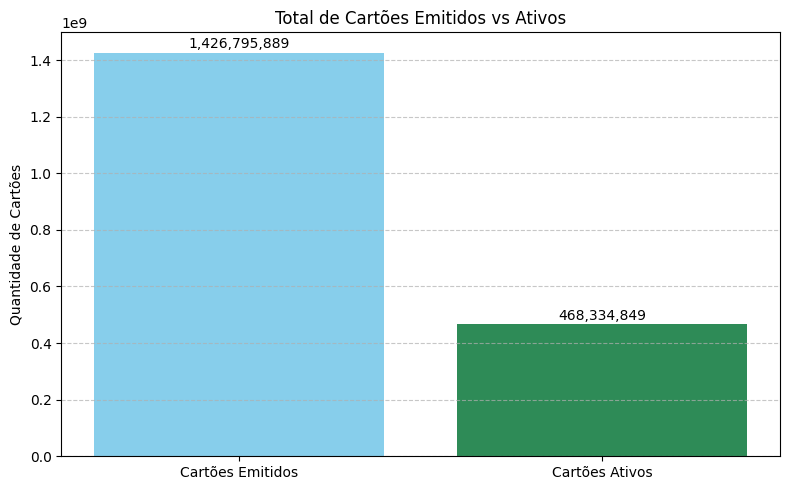

In [11]:
import matplotlib.pyplot as plt

valores = [total_emitidos, total_ativos]
categorias = ['Cartões Emitidos', 'Cartões Ativos']

plt.figure(figsize=(8, 5))
plt.bar(categorias, valores, color=['skyblue', 'seagreen'])
plt.title('Total de Cartões Emitidos vs Ativos')
plt.ylabel('Quantidade de Cartões')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, valor in enumerate(valores):
    plt.text(i, valor + max(valores)*0.01, f"{valor:,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

<h4>Media de cartões ativos e emitidos</h4>

In [12]:
print("Média de cartões emitidos:", df["qtdcartoesemitidos"].mean())
print("Média de cartões ativos:", df["qtdcartoesativos"].mean())

Média de cartões emitidos: 14267958.89
Média de cartões ativos: 4683348.49


<h4>Gráfico de Barras – Médias de Cartões Emitidos vs Ativos</h4>

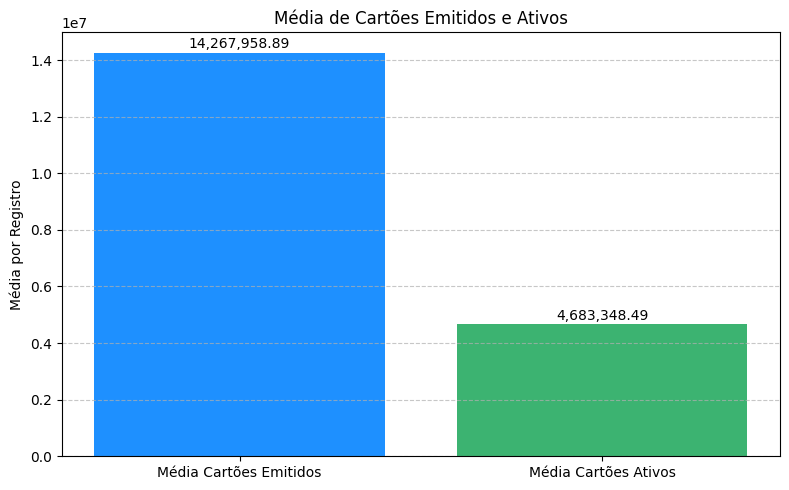

In [13]:
media_emitidos = df["qtdcartoesemitidos"].mean()
media_ativos = df["qtdcartoesativos"].mean()

medias = [media_emitidos, media_ativos]
categorias = ['Média Cartões Emitidos', 'Média Cartões Ativos']

plt.figure(figsize=(8, 5))
plt.bar(categorias, medias, color=['dodgerblue', 'mediumseagreen'])
plt.title('Média de Cartões Emitidos e Ativos')
plt.ylabel('Média por Registro')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, valor in enumerate(medias):
    plt.text(i, valor + max(medias)*0.01, f"{valor:,.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

<h4>Top 5 Bandeiras com Mais Cartões Emitidos</h4>

In [14]:
top_bandeiras = df.groupby("nomebandeira")["qtdcartoesemitidos"].sum().sort_values(ascending=False).head(5)

print("-" * 45)
for bandeira, valor in top_bandeiras.items():
    print(f" - {bandeira}: {valor:,} cartões")
print("-" * 45)

---------------------------------------------
 - VISA: 652,181,806 cartões
 - MasterCard: 440,540,421 cartões
 - Elo: 287,897,383 cartões
 - Bandeira própria: 27,316,395 cartões
 - Outras: 16,834,654 cartões
---------------------------------------------


<h4>Gráfico de Barras Horizontal – Top 5 Bandeiras por Cartões Emitidos</h4>

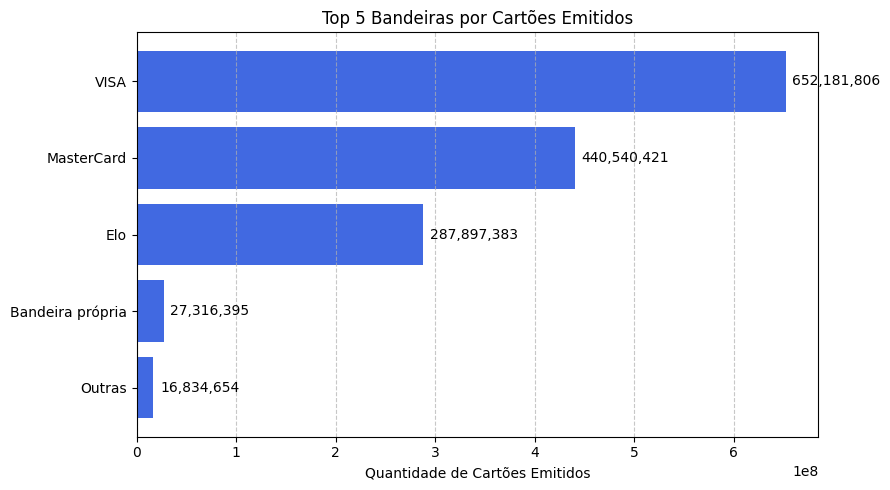

In [15]:
top_bandeiras = df.groupby("nomebandeira")["qtdcartoesemitidos"].sum().sort_values(ascending=False).head(5)

bandeiras = top_bandeiras.index
valores = top_bandeiras.values

plt.figure(figsize=(9, 5))
plt.barh(bandeiras, valores, color='royalblue')
plt.title('Top 5 Bandeiras por Cartões Emitidos')
plt.xlabel('Quantidade de Cartões Emitidos')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, valor in enumerate(valores):
    plt.text(valor + max(valores)*0.01, i, f"{valor:,}", va='center')

plt.tight_layout()
plt.show()

<h4>Top Funções de Cartão (por Cartões Emitidos)</h4>

In [16]:
top_funcoes = df.groupby("nomefuncao")["qtdcartoesemitidos"].sum().sort_values(ascending=False).head(5)

print("-" * 45)
for funcao, valor in top_funcoes.items():
    print(f" - {funcao}: {valor:,} cartões")
print("-" * 45)

---------------------------------------------
 - Débito: 501,083,571 cartões
 - Crédito: 488,096,213 cartões
 - Pré-Pago: 437,616,105 cartões
---------------------------------------------


<h4>Gráfico de Barras Horizontal – Top Funções de Cartão (por Cartões Emitidos)</h4>

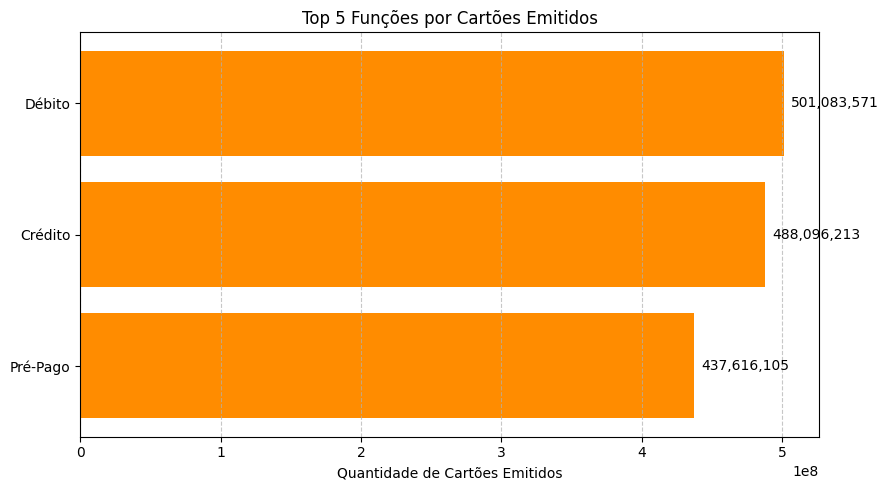

In [17]:
top_funcoes = df.groupby("nomefuncao")["qtdcartoesemitidos"].sum().sort_values(ascending=False).head(5)

funcoes = top_funcoes.index
valores = top_funcoes.values

plt.figure(figsize=(9, 5))
plt.barh(funcoes, valores, color='darkorange')
plt.title('Top 5 Funções por Cartões Emitidos')
plt.xlabel('Quantidade de Cartões Emitidos')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, valor in enumerate(valores):
    plt.text(valor + max(valores)*0.01, i, f"{valor:,}", va='center')

plt.tight_layout()
plt.show()


<h4>Top 5 Produtos</h4>

In [18]:
top_produtos = df.groupby("produto")["qtdcartoesemitidos"].sum().sort_values(ascending=False).head(5)

print("-" * 45)
for produto, valor in top_produtos.items():
    print(f" - {produto}: {valor:,} cartões")
print("-" * 45)

---------------------------------------------
 - Básico Internacional: 577,355,867 cartões
 - Básico Nacional: 335,385,427 cartões
 - Intermediário: 255,627,561 cartões
 - Outros: 105,736,276 cartões
 - Platinum: 57,128,993 cartões
---------------------------------------------


<h4>Gráfico de Barras Horizontal – Top 5 Produtos por Cartões Emitidos</h4>

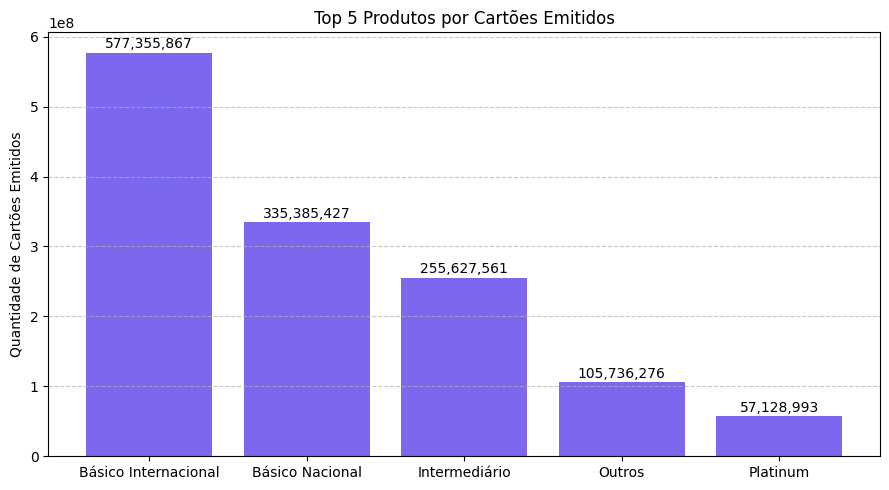

In [19]:
top_produtos = df.groupby("produto")["qtdcartoesemitidos"].sum().sort_values(ascending=False).head(5)

produtos = top_produtos.index
valores = top_produtos.values

plt.figure(figsize=(9, 5))
plt.bar(produtos, valores, color='mediumslateblue')
plt.title('Top 5 Produtos por Cartões Emitidos')
plt.ylabel('Quantidade de Cartões Emitidos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, valor in enumerate(valores):
    plt.text(i, valor + max(valores)*0.01, f"{valor:,}", ha='center')

plt.tight_layout()
plt.show()

<h4>Filtragem e agregação dos dados</h4>

Filtramos os dados para considerar apenas a função **"Crédito"** e, em seguida, agrupamos a quantidade de cartões emitidos por trimestre. Esses dados serão utilizados para gerar o gráfico.

In [20]:
df_credito = df[df["nomefuncao"] == "Crédito"]

df_emitidos = df_credito.groupby("trimestre")["qtdcartoesemitidos"].sum().sort_index()

trimestres = df_emitidos.index
valores = df_emitidos.values

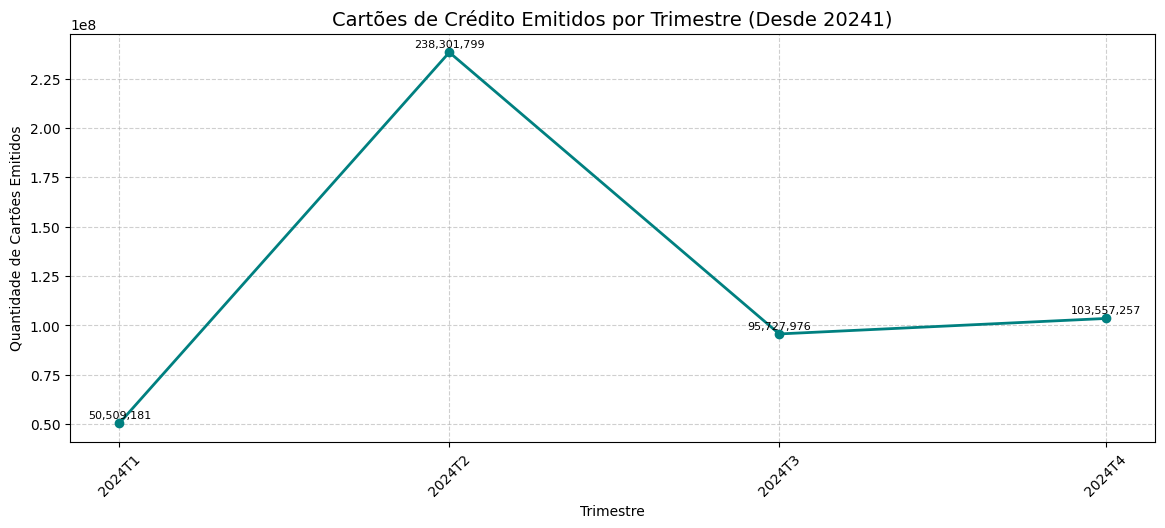

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(trimestres, valores, marker='o', color='teal', linewidth=2)
ax.set_title('Cartões de Crédito Emitidos por Trimestre (Desde 20241)', fontsize=14)
ax.set_xlabel('Trimestre')
ax.set_ylabel('Quantidade de Cartões Emitidos')
ax.set_xticks(trimestres)
ax.set_xticklabels([f"{d.year}T{((d.month-1)//3)+1}" for d in trimestres], rotation=45)
ax.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(trimestres, valores):
    ax.text(x, y + max(valores) * 0.01, f"{y:,}", ha='center', fontsize=8)
plt.subplots_adjust(bottom=0.2)
plt.show()


Cartões Ativos por Trimestre

In [22]:
df_ativos = df.groupby("trimestre")["qtdcartoesativos"].sum().sort_index()
trimestres_ativos = df_ativos.index
valores_ativos = df_ativos.values

print("-" * 45)
print("")
for trimestre in trimestres_ativos:
    print(f" Trimestre {trimestre}: {df_ativos[trimestre]:,} cartões ativos\n")
print("-" * 45)

---------------------------------------------

 Trimestre 2024-03-01 00:00:00: 95,435,516 cartões ativos

 Trimestre 2024-06-01 00:00:00: 180,025,523 cartões ativos

 Trimestre 2024-09-01 00:00:00: 78,494,073 cartões ativos

 Trimestre 2024-12-01 00:00:00: 114,379,737 cartões ativos

---------------------------------------------


Percentual de Ativos sobre Emitidos por Trimestre

In [23]:
df_emitidos = df.groupby("trimestre")["qtdcartoesemitidos"].sum()
df_ativos = df.groupby("trimestre")["qtdcartoesativos"].sum()

print("-" * 45)
print("")
for trimestre in df_emitidos.index:
    emitidos = df_emitidos[trimestre]
    ativos = df_ativos[trimestre]
    percentual = (ativos / emitidos * 100) if emitidos > 0 else 0

    print(f"Trimestre {trimestre}: {percentual:.2f}% ativos\n")
print("-" * 45)

---------------------------------------------

Trimestre 2024-03-01 00:00:00: 44.10% ativos

Trimestre 2024-06-01 00:00:00: 29.38% ativos

Trimestre 2024-09-01 00:00:00: 41.14% ativos

Trimestre 2024-12-01 00:00:00: 28.12% ativos

---------------------------------------------


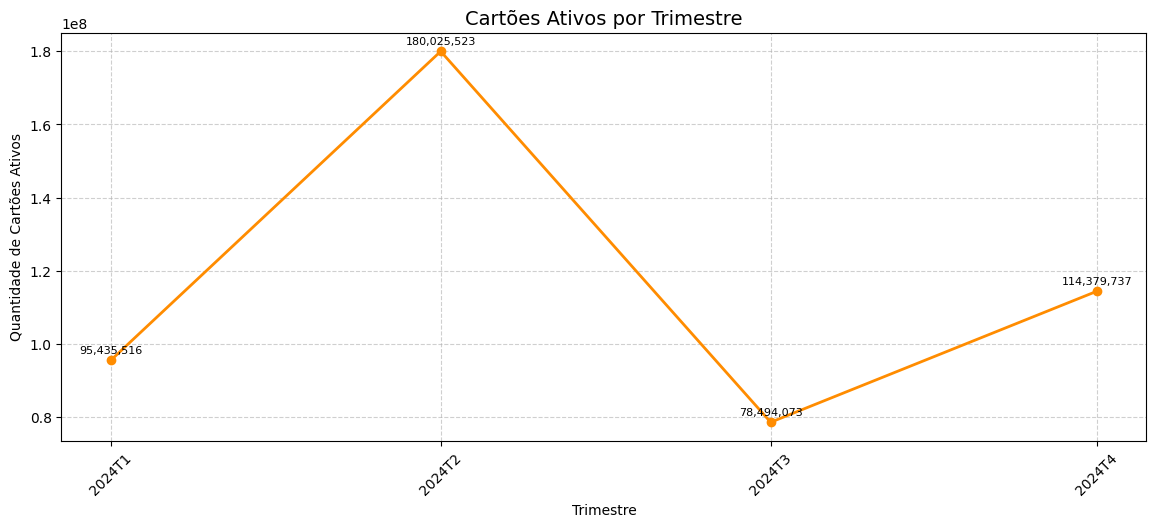

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(trimestres_ativos, valores_ativos, marker='o', color='darkorange', linewidth=2)
ax.set_title('Cartões Ativos por Trimestre', fontsize=14)
ax.set_xlabel('Trimestre')
ax.set_ylabel('Quantidade de Cartões Ativos')
ax.set_xticks(trimestres)
ax.set_xticklabels([f"{d.year}T{((d.month-1)//3)+1}" for d in trimestres], rotation=45)
plt.xticks(rotation=45)
ax.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(trimestres_ativos, valores_ativos):
    ax.text(x, y + max(valores_ativos)*0.01, f"{y:,}", ha='center', fontsize=8)

plt.subplots_adjust(bottom=0.2)
plt.show()


<h4>Trimestre com maior e menor emissão</h4>
Ver qual trimestre teve o maior e menor número de cartões emitidos.

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_emitidos_total = df.groupby("trimestre")["qtdcartoesemitidos"].sum().sort_index()
max_emitido = df_emitidos_total.idxmax()
min_emitido = df_emitidos_total.idxmin()


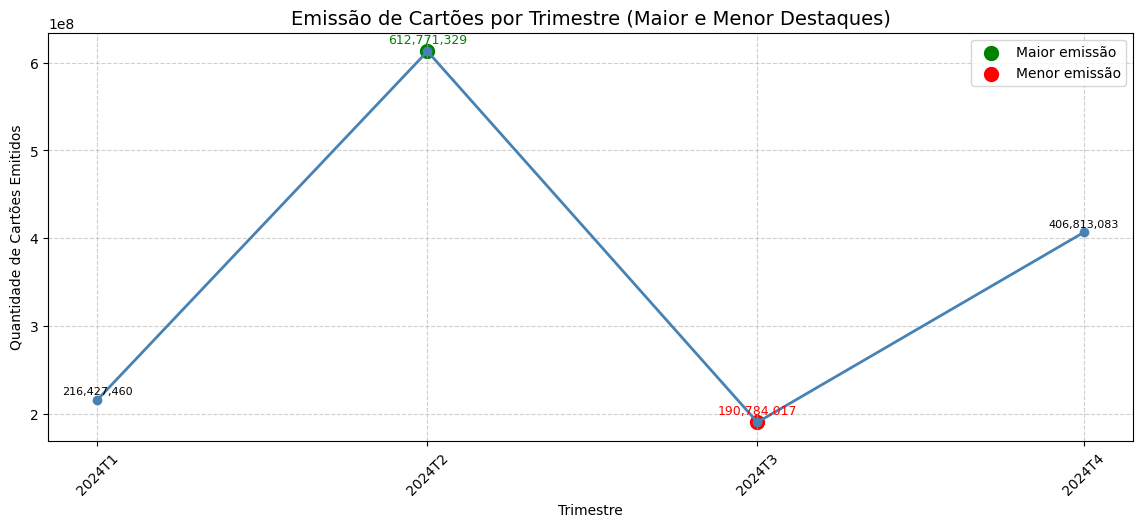

In [26]:
trimestres = df_emitidos_total.index
valores = df_emitidos_total.values

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(trimestres, valores, marker='o', color='steelblue', linewidth=2)

ax.set_title('Emissão de Cartões por Trimestre (Maior e Menor Destaques)', fontsize=14)
ax.set_xlabel('Trimestre')
ax.set_ylabel('Quantidade de Cartões Emitidos')

ax.set_xticks(trimestres)
ax.set_xticklabels([f"{d.year}T{((d.month-1)//3)+1}" for d in trimestres], rotation=45)

plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.6)

for trimestre, valor in zip(trimestres, valores):
    if trimestre == max_emitido:
        ax.scatter(trimestre, valor, color='green', s=100, label='Maior emissão')
        ax.text(trimestre, valor + max(valores)*0.015, f"{valor:,}", ha='center', fontsize=9, color='green')
    elif trimestre == min_emitido:
        ax.scatter(trimestre, valor, color='red', s=100, label='Menor emissão')
        ax.text(trimestre, valor + max(valores)*0.015, f"{valor:,}", ha='center', fontsize=9, color='red')
    else:
        ax.text(trimestre, valor + max(valores)*0.01, f"{valor:,}", ha='center', fontsize=8)

ax.legend()
plt.subplots_adjust(bottom=0.2)
plt.show()

<h4>Cartões ativos sobre emitidos por função (crédito, débito…)</h4>
Pra ver qual tipo de cartão tem maior taxa de ativação.

In [27]:
df_func = df.groupby("nomefuncao")[["qtdcartoesemitidos", "qtdcartoesativos"]].sum()
df_func["percentual_ativo"] = (df_func["qtdcartoesativos"] / df_func["qtdcartoesemitidos"]) * 100

for funcao in df_func.index:
    print(f"{funcao}: {df_func.loc[funcao, 'percentual_ativo']:.2f}% ativos")

Crédito: 47.99% ativos
Débito: 24.14% ativos
Pré-Pago: 25.86% ativos


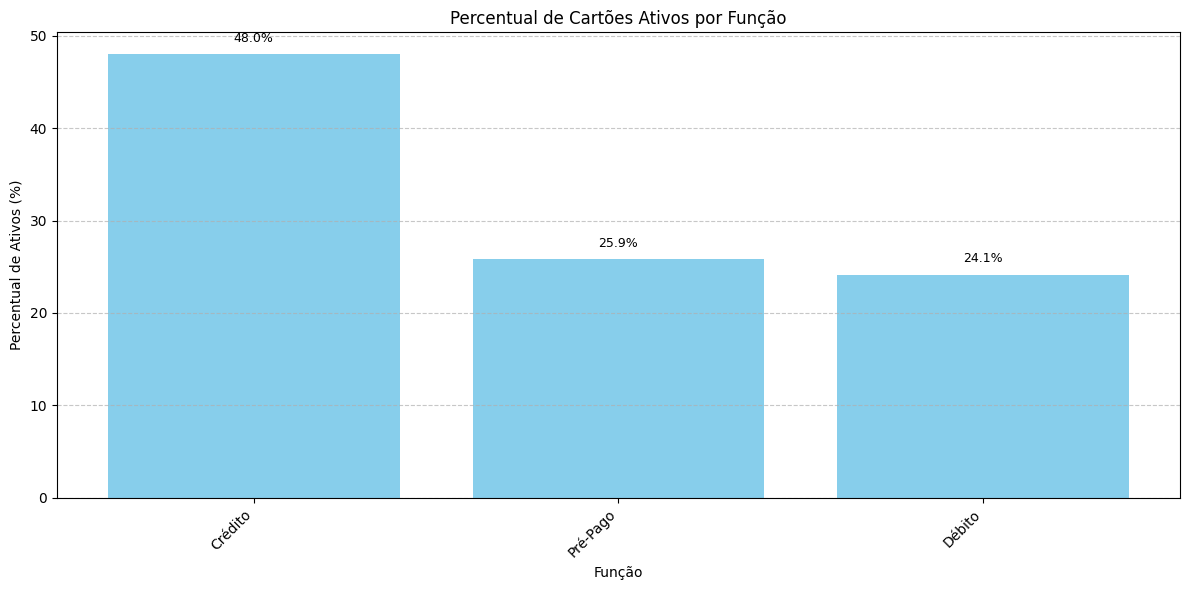

In [28]:
df_func = df.groupby("nomefuncao")[["qtdcartoesemitidos", "qtdcartoesativos"]].sum()
df_func["percentual_ativo"] = (df_func["qtdcartoesativos"] / df_func["qtdcartoesemitidos"]) * 100

plt.figure(figsize=(12, 6))
percentuais = df_func["percentual_ativo"].sort_values(ascending=False)
bars = plt.bar(percentuais.index, percentuais.values, color="skyblue")

plt.title("Percentual de Cartões Ativos por Função")
plt.ylabel("Percentual de Ativos (%)")
plt.xlabel("Função")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Produto ou bandeira com mais cartões ativos (ou maior % de ativação)

In [29]:
df_prod = df.groupby("produto")[["qtdcartoesemitidos", "qtdcartoesativos"]].sum()
df_prod["percentual_ativo"] = (df_prod["qtdcartoesativos"] / df_prod["qtdcartoesemitidos"]) * 100
df_prod = df_prod.sort_values("percentual_ativo", ascending=False)

print("Top 5 produtos com maior taxa de ativação:\n")
for produto in df_prod.head(5).index:
    print(f"{produto}: {df_prod.loc[produto, 'percentual_ativo']:.2f}%")


Top 5 produtos com maior taxa de ativação:

Premium: 67.11%
Platinum: 65.20%
Intermediário: 51.52%
Empresarial: 40.95%
Corporativo: 28.83%


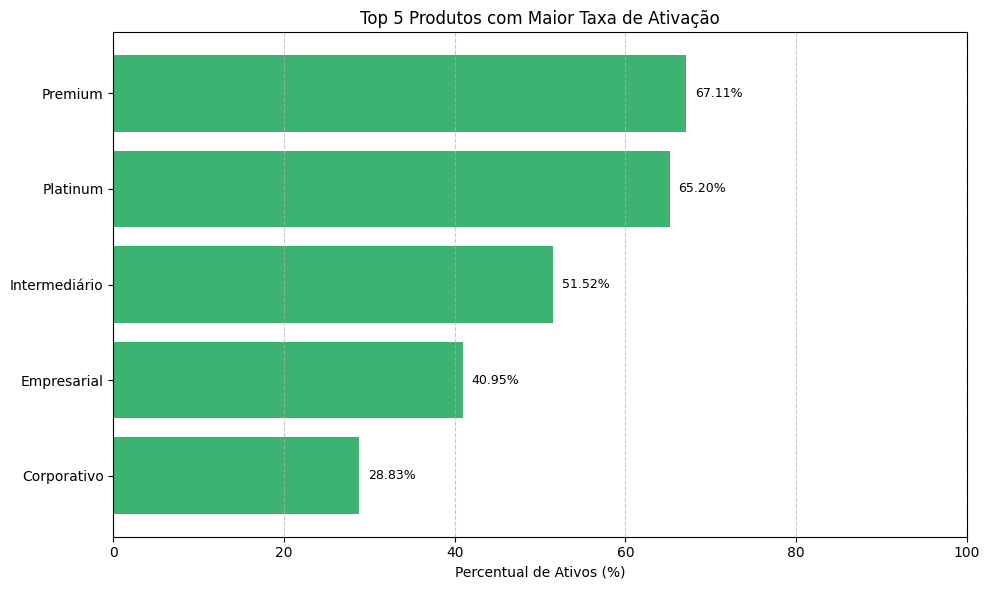

In [30]:
df_prod = df.groupby("produto")[["qtdcartoesemitidos", "qtdcartoesativos"]].sum()
df_prod["percentual_ativo"] = (df_prod["qtdcartoesativos"] / df_prod["qtdcartoesemitidos"]) * 100
df_prod = df_prod.sort_values("percentual_ativo", ascending=False)

top5 = df_prod.head(5)

plt.figure(figsize=(10, 6))
bars = plt.barh(top5.index[::-1], top5["percentual_ativo"][::-1], color="mediumseagreen")

plt.title("Top 5 Produtos com Maior Taxa de Ativação")
plt.xlabel("Percentual de Ativos (%)")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [31]:
df_prod = df.groupby("produto")[["qtdcartoesemitidos", "qtdcartoesativos"]].sum()
df_prod["percentual_ativo"] = (df_prod["qtdcartoesativos"] / df_prod["qtdcartoesemitidos"]) * 100
df_prod = df_prod.sort_values("percentual_ativo", ascending=True)

print("Top 5 produtos com menor taxa de ativação:\n")
for produto in df_prod.head(5).index:
    print(f"{produto}: {df_prod.loc[produto, 'percentual_ativo']:.2f}%")


Top 5 produtos com menor taxa de ativação:

Básico Nacional: 22.93%
Básico Internacional: 25.65%
Outros: 28.23%
Corporativo: 28.83%
Empresarial: 40.95%


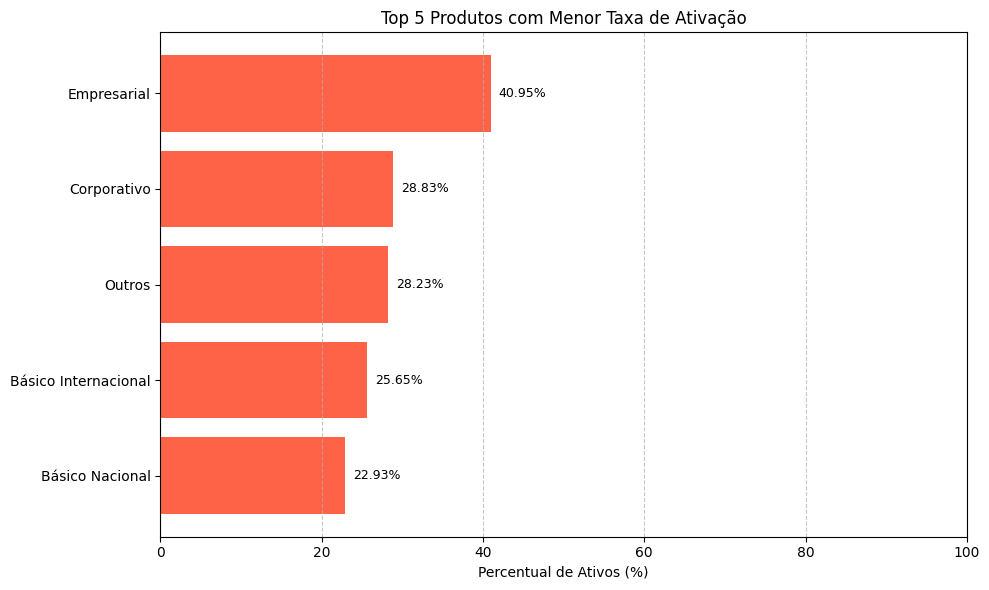

In [32]:
df_prod = df.groupby("produto")[["qtdcartoesemitidos", "qtdcartoesativos"]].sum()
df_prod["percentual_ativo"] = (df_prod["qtdcartoesativos"] / df_prod["qtdcartoesemitidos"]) * 100
df_prod = df_prod.sort_values("percentual_ativo", ascending=True)

top5_menor = df_prod.head(5)

plt.figure(figsize=(10, 6))
bars = plt.barh(top5_menor.index, top5_menor["percentual_ativo"], color="tomato")

plt.title("Top 5 Produtos com Menor Taxa de Ativação")
plt.xlabel("Percentual de Ativos (%)")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [33]:
df.to_csv('estoque_cartoes_20241.csv',sep=';',decimal=',')